## Setup
### Project setup

In [3]:
if run_init:
    %pip install -U pip
    !if  [ ! -d "deep-learning-project" ] ; then git clone https://github.com/albertsgarde/deep-learning-project.git; fi
    !cd deep-learning-project && git reset --hard && git pull
    !source deep-learning-project/setup.sh deep-learning-project
run_init = False

In [4]:
run_init = True

In [5]:
run_init = False

### Imports

In [6]:
import matplotlib.pyplot as plt
import IPython.display as display

import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as nn_func
import torch.optim as optim
from torch.autograd import Variable

import audio_samples_py as aus

### Device setup

In [7]:
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")
print("Running GPU.") if use_cuda else print("No GPU available.")

No GPU available.


## Data
### Parameters

In [8]:
SAMPLE_LENGTH = 256
BATCH_SIZE = 64

parameters = aus.DataParameters(num_samples=SAMPLE_LENGTH).add_sine((0.5,0.75))

### Generation

In [9]:
import warnings

class AudioDataSet(torch.utils.data.Dataset):
    def __init__(self, parameters: aus.DataParameters):
         self.parameters = parameters

    def __len__(self):
        return np.iinfo(np.int64).max
    
    def __getitem__(self, index):
        data_point = self.parameters.generate_at_index(index)
        return data_point.samples(), torch.tensor([data_point.frequency_map()]).unsqueeze(0)



In [10]:
data_loader_params = {"batch_size": BATCH_SIZE}

training_parameters = parameters.with_seed_offset(0)
training_loader = torch.utils.data.DataLoader(AudioDataSet(training_parameters), **data_loader_params)
validation_parameters = parameters.with_seed_offset(1)
validation_generator = aus.DataGenerator(validation_parameters)
validation_loader = torch.utils.data.DataLoader(AudioDataSet(validation_parameters), **data_loader_params)


In [11]:
def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

## Neural Network

### Network Parameters

In [12]:
conv_depth = 2
channels = [8, 8, 8, 8]
kernel_sizes = [5, 5, 5, 5]
strides = [1 for _ in range(conv_depth)]
paddings = [int((kernel_size - 1)/2) for kernel_size in kernel_sizes]
poolings = [2,2,2,2]
conv_batch_norms = [False for _ in range(conv_depth)]
conv_dropouts = [0.0 for _ in range(conv_depth)]
#TEST

lin_depth = 2
features = [256, 128]
lin_batch_norms = [False for _ in range(lin_depth)]
lin_dropouts = [0.0 for _ in range(lin_depth)]

### Parameter validation and processing

In [13]:
assert len(channels) >= conv_depth
assert len(kernel_sizes) >= conv_depth
assert len(strides) >= conv_depth
assert len(paddings) >= conv_depth
assert len(poolings) >= conv_depth
assert len(conv_batch_norms) >= conv_depth
assert len(conv_dropouts) >= conv_depth
for kernel_size in kernel_sizes:
    assert kernel_size % 2 == 1, "Only odd kernel sizes are supported."
for dropout in conv_dropouts:
    assert 0 <= dropout and dropout <= 1, "Dropout must be between 0 and 1."

conv_size = []
input_size = SAMPLE_LENGTH
for i in range(conv_depth):
    conv_dim_reduction = kernel_sizes[i]-1-paddings[i]*2
    assert (input_size - conv_dim_reduction) % (strides[i]*poolings[i]) == 0
    conv_size.append(int((input_size - conv_dim_reduction)/strides[i]/poolings[i]))
    input_size = conv_size[i]
    print("Conv layer {} has output size {} and {} channels.".format(i, conv_size[i], channels[i]))

conv_output_size = conv_size[-1]*channels[-1]


assert len(features) >= lin_depth
assert len(lin_batch_norms) >= lin_depth
assert len(lin_dropouts) >= lin_depth
for dropout in lin_dropouts:
    assert 0 <= dropout and dropout <= 1, "Dropout must be between 0 and 1."
for i in range(lin_depth):
    print("Lin layer {} has output size {}.".format(i, features[i]))

Conv layer 0 has output size 128 and 8 channels.
Conv layer 1 has output size 64 and 8 channels.
Lin layer 0 has output size 256.
Lin layer 1 has output size 128.


### Network

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convs = nn.ModuleList()
        in_channels = 1
        for i in range(conv_depth):
            conv = nn.Conv1d(in_channels=in_channels, out_channels=channels[i], kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i])
            in_channels = channels[i]
            pool = nn.MaxPool1d(poolings[i])
            batchnorm = nn.BatchNorm1d(channels[i]) if (conv_batch_norms[i]) else nn.Identity()
            dropout = nn.Dropout(p=conv_dropouts[i])

            self.convs.append(nn.ModuleList([conv, pool, batchnorm, dropout]))
        
        self.lins = nn.ModuleList()
        in_features = conv_output_size
        for i in range(lin_depth):
            lin = nn.Linear(in_features=in_features, out_features=features[i])
            in_features = features[i]
            batchnorm = nn.BatchNorm1d(features[i]) if (lin_batch_norms[i]) else nn.Identity()
            dropout = nn.Dropout(p=lin_dropouts[i])

            self.lins.append(nn.ModuleList([lin, batchnorm, dropout]))

        self.lin_out = nn.Linear(in_features=in_features, out_features=1)
        
        
    def forward(self, x):
        x = x.unsqueeze(1)

        for conv, pool, batchnorm, dropout in self.convs:
            x = conv(x)
            x = pool(x)
            x = nn_func.relu(x)
            x = batchnorm(x)
            x = dropout(x)

        x = x.flatten(1)

        for lin, batchnorm, dropout in self.lins:
            x = lin(x)
            x = nn_func.relu(x)
            x = batchnorm(x)
            x = dropout(x)
            
        return self.lin_out(x).unsqueeze(1)

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (convs): ModuleList(
    (0): ModuleList(
      (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Identity()
      (3): Dropout(p=0.0, inplace=False)
    )
    (1): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Identity()
      (3): Dropout(p=0.0, inplace=False)
    )
  )
  (lins): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): Identity()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): ModuleList(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): Identity()
      (2): Dropout(p=0.0, inplace=False)
    )
  )
  (lin_out): Linear(in_features=128, out_features=1, bias=True)
)


## Training

In [15]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-5

In [16]:
criterion = nn.MSELoss()  

# weight_decay is equal to L2 regularization
optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) 

In [17]:
def to_torch(x):
    variable = Variable(torch.from_numpy(x))
    if use_cuda:
        variable = variable.cuda()
    return variable

def mean_cent_err(freq_map, output):
    target_frequency = np.array(list(map(parameters.map_to_frequency, get_numpy(freq_map))))
    output_frequency = np.array(list(map(parameters.map_to_frequency, get_numpy(output))))
    return np.array([abs(aus.cent_diff(target_frequency, output_frequency)) for target_frequency, output_frequency in zip(target_frequency, output_frequency)]).mean()

def test_net(net, validation_loader, criterion):
    was_training = net.training
    net.eval()
    num_iterations = 100
    total_loss = 0
    total_cent_diff = 0
    for data_point, freq_map in itertools.islice(validation_loader, num_iterations):
        data_point = data_point.to(device)
        freq_map = freq_map.to(device)
        output = net(data_point)
        
        total_loss += criterion(output, freq_map)
        total_cent_diff += mean_cent_err(freq_map, output)
    net.train(mode=was_training)
    return total_loss.item()/num_iterations, total_cent_diff/num_iterations

def manual_test(net, validation_generator):
    was_training = net.training
    net.eval()
    num_iterations = 5
    for data_point in validation_generator.next_n(num_iterations):
        samples = to_torch(data_point.samples()).unsqueeze(0)
        freq_map = to_torch(np.array([data_point.frequency_map()])).unsqueeze(0)
        output = net(samples)
        target_frequency = parameters.map_to_frequency(freq_map.item())
        output_frequency = parameters.map_to_frequency(output.item())
        print("Frequency: {:.2f} Output: {:.2f} Cent diff: {:.2f}".format(target_frequency, output_frequency, aus.cent_diff(target_frequency, output_frequency)))
    net.train(mode=was_training)



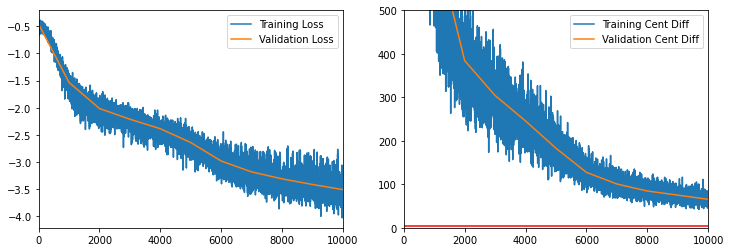

10000: Loss=0.00030864624306559563, Cent diff=65.42
Frequency: 21.81 Output: 23.20 Cent diff: 107.59
Frequency: 7476.91 Output: 7185.52 Cent diff: -68.82
Frequency: 50.53 Output: 48.85 Cent diff: -58.78
Frequency: 10745.43 Output: 9747.90 Cent diff: -168.67
Frequency: 18996.28 Output: 21595.53 Cent diff: 222.02


In [18]:
NUM_BATCHES = 10000
EVAL_EVERY = 1000
LOG_EVERY = EVAL_EVERY


train_log_losses = []
train_diffs = []
train_iter = []

val_log_losses = []
val_diffs = []
val_iter = []

net.train()
for i, (data_point, frequency_map) in enumerate(itertools.islice(training_loader, NUM_BATCHES+1)):
    if i%EVAL_EVERY == 0:
        val_loss, val_cent_diff = test_net(net, validation_loader, criterion)
        val_log_losses.append(np.log10(val_loss))
        val_diffs.append(val_cent_diff)
        val_iter.append(i)

    data_point = data_point.to(device)
    frequency_map = frequency_map.to(device)
    output = net(data_point)
    loss = criterion(output, frequency_map)

    
    train_log_losses.append(np.log10(loss.item()))
    train_diffs.append(mean_cent_err(frequency_map, output))
    train_iter.append(i)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % LOG_EVERY == 0:
        display.clear_output(wait=True)
        fig = plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_log_losses, label="Training Loss")
        plt.plot(val_iter, val_log_losses, label="Validation Loss")
        plt.xlim(0, NUM_BATCHES+1)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_diffs, label="Training Cent Diff")
        plt.plot(val_iter, val_diffs, label="Validation Cent Diff")
        plt.axhline(y=5, color='r', linestyle='-')
        plt.ylim(0, 500)
        plt.xlim(0, NUM_BATCHES+1)
        plt.legend()
        plt.show()

val_loss, val_cent_diff = test_net(net, validation_loader, criterion)
print(f"{i}: Loss={val_loss}, Cent diff={val_cent_diff:.2f}")

manual_test(net, validation_generator)


In [19]:
manual_test(net, validation_generator)
test_net(net, validation_loader, criterion)

Frequency: 260.95 Output: 258.69 Cent diff: -15.01
Frequency: 15659.84 Output: 15944.52 Cent diff: 31.19
Frequency: 5092.42 Output: 4851.57 Cent diff: -83.88
Frequency: 193.82 Output: 192.38 Cent diff: -12.90
Frequency: 387.67 Output: 394.60 Cent diff: 30.65


(0.00030864624306559563, 65.42186143621205)